# Example:
* # EXTRACT EMBEDDINGS from Directory of wav files using a pre-trained VGGVox for model
* # Store them in a Pandas Dada Frame with labels so we can then Obtain the distance between them
* # Visualize 2D proyected embeddings of different speakers using PCA and tSNE


### See previous VGGVOx Notebooks and also:

https://github.com/Derpimort/VGGVox-PyTorch

https://rzimmermann.com/coding/vggvox-pytorch


* ## Clonar el github: VGGVox PyTorch

In [1]:
! git clone https://github.com/Derpimort/VGGVox-PyTorch.git

Cloning into 'VGGVox-PyTorch'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 101 (delta 1), reused 5 (delta 1), pack-reused 93
Receiving objects: 100% (101/101), 64.81 MiB | 36.93 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
ls ./VGGVox-PyTorch/

data/    models/        README.md         results.txt      test.wav  vggm.py
LICENSE  model_test.py  requirements.txt  signal_utils.py  train.py


## * Change the current directory to /content/VGGVox-PyTorch

In [3]:
cd /content/VGGVox-PyTorch


/content/VGGVox-PyTorch


# Install packages
# <font color=red>WARNING!!! once installed, you have to reset the virtual machine (see the warning message)

In [4]:
! pip install -r requirements.txt

# LET's see what data do we need

In [5]:
ls -al ./data/

total 5228
drwxr-xr-x 2 root root    4096 Dec 17 10:38 ./
drwxr-xr-x 5 root root    4096 Dec 17 10:38 ../
-rw-r--r-- 1 root root 4912512 Dec 17 10:38 iden_split.txt
-rw-r--r-- 1 root root  387503 Dec 17 10:38 val.pkl
-rw-r--r-- 1 root root   40782 Dec 17 10:38 vox1_meta.csv


# Create a wav directory inside data

In [6]:
cd ./data

/content/VGGVox-PyTorch/data


In [7]:
! mkdir ./wav

# Mount our Google Drive and copy some wav files

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
ls /content/drive/'My Drive'/VGGVOX_PyTorch

id10270.zip                    VGGVox_Distance_Embedding.ipynb
id10275.zip                    VGGVox_Embeddings_EmoPCFBorja_wavDir_SVM.ipynb
loc1/                          VGGVox_Embeddings_Simple.ipynb
loc2/                          VGGVox_Embeddings_wavDir.ipynb
MLLB_Keras_FontReco_CNN.ipynb  VGGVox_Embed_Female_Male_wavDir.ipynb
MLLB_OSA_Simple_PCA.ipynb      VGGVox_Embed_Female_Male_wavDir_SVM.ipynb
PFCBorjaGAPS.zip               wavEmo_females_males.zip
VGGVox_1.ipynb                 wav.zip


In [10]:
cd /content/VGGVox-PyTorch/data/wav/

/content/VGGVox-PyTorch/data/wav


* # We copy a zip file from Google Drive that contains audios from 4 VoxCeleb speaker

In [11]:
cp -rf /content/drive/'My Drive'/VGGVOX_PyTorch/wav.zip /content/VGGVox-PyTorch/data/wav/.

In [12]:
! unzip -q /content/VGGVox-PyTorch/data/wav/wav.zip

In [13]:
! rm /content/VGGVox-PyTorch/data/wav/wav.zip

In [15]:
ls /content/VGGVox-PyTorch/data/wav

10270/  10275/  10279/  10285/


In [14]:
ls /content/VGGVox-PyTorch/data/wav/10270

00001.wav  00003.wav  00005.wav  00007.wav  00009.wav  00011.wav  00013.wav
00002.wav  00004.wav  00006.wav  00008.wav  00010.wav  00012.wav  00014.wav


# **Create a Data Frame with all the wav files and labels**

In [21]:
import pandas as pd
import os
import numpy as np
import re


DATA_DIR = '/content/VGGVox-PyTorch/data/wav'

data_wav = []

start_path = '/content/VGGVox-PyTorch/data/wav' # wav
for path,dirs,files in os.walk(start_path):
    for filename in files:
      #print(path)
      #print(filename)
      #print(os.path.join(path,filename))
      #label = int(re.sub('loc',  '', path.split('/')[-1])) + 10000
      label = int(path.split('/')[-1])
      data_wav.append([3, path.split('/')[-1] + '/' + filename, label])


df_F = pd.DataFrame(data_wav,columns = ['Set', 'Path', 'Label'])

In [22]:
df_F.head(20)

,Set,Path,Label
0,3,10275/00012.wav,10275
1,3,10275/00002.wav,10275
2,3,10275/00004.wav,10275
3,3,10275/00008.wav,10275
4,3,10275/00011.wav,10275
5,3,10275/00005.wav,10275
6,3,10275/00010.wav,10275
7,3,10275/00003.wav,10275
8,3,10275/00006.wav,10275
9,3,10275/00007.wav,10275


* ## **IT IS IMPORTANT TO MOVE to the VGGVox-PyTorch directory**

In [16]:
cd /content/VGGVox-PyTorch

/content/VGGVox-PyTorch



---

# Load the pre-trained VGGVox model

In [23]:
import torch
from torch.utils.data import Subset, Dataset, DataLoader
from tqdm.auto import tqdm
from vggm import VGGM
import argparse
from train import AudioDataset, accuracy, ppdf, LOCAL_DATA_DIR, MODEL_DIR
from sklearn.metrics.pairwise import cosine_similarity


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=VGGM(1251)
#model.load_state_dict(torch.load(DATA_DIR+"/VGGMVAL_BEST_149_80.84.pth", map_location=device))
model.load_state_dict(torch.load(MODEL_DIR+"VGGM300_BEST_140_81.99.pth", map_location=device))
model.to(device)
model.eval()

### This is to extract an activation from one layer ...

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# **Create a function to obtaing embeddings from the wav files in DataFrame df_F and <font color=red>adds the embedding vector of each wav file to df_F</font>**

In [24]:

DATA_DIR = '/content/VGGVox-PyTorch/data/wav'

Datasets={
        "test":AudioDataset(df_F, DATA_DIR, is_train=False)}

Dataloaders={i:DataLoader(Datasets[i], batch_size=1, shuffle=False, num_workers=2) for i in Datasets}

embedding_arr = []

for audio, labels in Dataloaders['test']:
        audio = audio.to(device)
        labels = labels.to(device)
        model.classifier.fc7.register_forward_hook(get_activation('fc7'))
        outputs = model(audio)

        embedding_arr.append(activation['fc7'].cpu().numpy().reshape(-1))

df_F['Embeddings'] = pd.Series(embedding_arr)

In [25]:
df_F.head()

,Set,Path,Label,Embeddings
0,3,10275/00012.wav,10275,"[-2.5265585e-11, -5.232177e-11, -4.657694e-10,..."
1,3,10275/00002.wav,10275,"[-2.540411e-11, -5.3375283e-11, -4.970576e-10,..."
2,3,10275/00004.wav,10275,"[-2.7144125e-11, -5.4595092e-11, -5.168791e-10..."
3,3,10275/00008.wav,10275,"[-2.4583419e-11, -4.926766e-11, -4.6918575e-10..."
4,3,10275/00011.wav,10275,"[-2.3190292e-11, -5.5895462e-11, -5.017277e-10..."


# PCA visualization

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

### LET's try with the same number of components than features
### KNOW what defines the limit
n_components = 5

X = np.stack(df_F['Embeddings'].values)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

pca = PCA(n_components = n_components)

pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

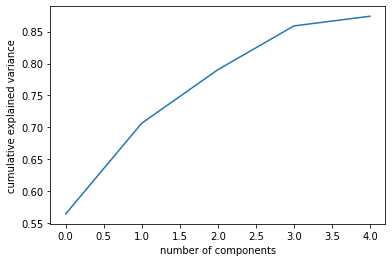

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [31]:
df_F['Label'].unique()

array([10275, 10285, 10270, 10279])

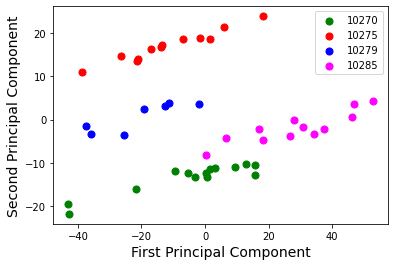

In [32]:
group = df_F['Label']
cdict = {10275: 'red', 10279: 'blue', 10270: 'green', 10285:'magenta'}

Z1 = pca.transform(X_scaled)[:,0] # see 'prcomp(my_data)$x' in R
Z2 = pca.transform(X_scaled)[:,1]

fig, ax = plt.subplots()
for g in np.unique(group):
  ix = np.where(group == g)
  ax.scatter(Z1[ix], Z2[ix], c = cdict[g], label = g, s = 50)

plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
ax.legend()

# We also visualize embeddings in 2D using t-SNE:</font>

[A TSNE Introduction](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)

### Although extremely useful for visualizing high-dimensional data, t-SNE plots can sometimes be mysterious or misleading. By exploring how it behaves in simple cases, we can learn to use it more effectively.
See https://distill.pub/2016/misread-tsne/

In [33]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

X_tsne = TSNE(random_state=123).fit_transform(X_scaled)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.2871060371398926 seconds


In [34]:
X_tsne.shape

(45, 2)

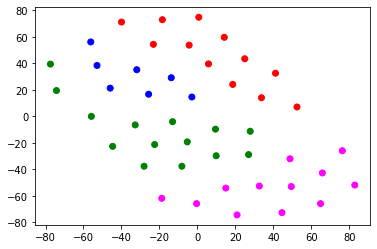

In [35]:
color = []
for label in df_F['Label']:
  if label == 10275:
      color.append('red')
  elif label == 10279:
      color.append('blue')
  elif label == 10270:
      color.append('green')
  elif label == 10285:
      color.append('magenta')
  

plt.scatter(X_tsne[:,0] ,X_tsne[:,1], c = color)